# Topic modelling with Gensim : the LDA algorithm

LDA is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.

### 1. Loading of the required libraries and vocabularies.
***



In [1]:
import gensim
import pandas as pd

import spacy
import sys

## Run once this chunk with the command below active. Then comment it out and run the notebook
!{sys.executable} -m spacy download en

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

import nltk
import re
import pprint
import os
import sys


from gensim import corpora

#import nltk
#from nltk import sent_tokenize
#from nltk.corpus import stopwords

##nltk.download('stopwords')
##stop_words = stopwords.words('english')

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from pprint import pprint



[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Pleaseuse the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Step 2. Pre-processing

* Read two files exported from the database which contain the SE Glossary articles definitions and their titles.
* In later versions, the **corresponding tables will be directly exported from the database**.
* Merge by_id_ and discard records with duplicate titles and/or definitions.


In [2]:
dat1= pd.read_csv("ESTAT_dat_concepts_2021_04_08.csv",sep=";")
dat2= pd.read_csv("ESTAT_dat_link_info_2021_04_08.csv",sep=";")
Gloss_concepts = pd.merge(dat1,dat2,on=['id'])
del(dat1,dat2)

Gloss_concepts = Gloss_concepts[['id','title','definition']]

Gloss_concepts = Gloss_concepts.drop_duplicates(subset=["definition"])
Gloss_concepts = Gloss_concepts.dropna(axis=0,subset=["definition"])
Gloss_concepts = Gloss_concepts.drop_duplicates(subset=["title"])
Gloss_concepts = Gloss_concepts.dropna(axis=0,subset=["title"])

Gloss_concepts.reset_index(drop=True, inplace=True)
Gloss_concepts

,id,title,definition
0,1,Arrival of tourist at a tourist accommodation ...,See arrival disambiguation page fo...
1,3,Nights spent,A night spent or tourism night ...
2,4,Supply side tourism statistics,Regulation (EU) No 692/2011 of 6 July 2011 e...
3,5,Tourist,"For tourism statistics, a travell..."
4,7,Asia-Europe Meeting (ASEM),"The Asia-Europe Meeting , abbreviated..."
...,...,...,...
1279,2879,Statistical territory,The statistical territory of the ...
1280,2881,Statistical indicator,A statistical indicator is the repres...
1281,2885,Tourism industries,For the article Tourism industries - eco...
1282,2891,Sawnwood,Sawnwood is wood that has been produced ...


### 3. Pre-processing input data (cont).
***

Next we tokenize the texts - definitions in the articles, delete stop words, apply Porter's stemmer, select final tokens  
with minimum length 5 and also convert everything to lowercase and drop accents. 

The result, _texts_ is a nested list with 1284 outer elements corresponding to the records in the dataframe _Gloss_concepts_.  
The inner lists contain the tokens for each text.

In [3]:
#Tokenize texts and clean-up text.
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.porter import PorterStemmer
def sent_to_words(sentences):
    p = PorterStemmer()
    for sentence in sentences:
        sentence = remove_stopwords(sentence) ## remove stop words
        
        tokens = gensim.utils.tokenize(sentence)
        sentence = [p.stem(token) for token in tokens if len(p.stem(token)) >= 5] ##minimum length = 5 
        #p.stem_sentence(sentence)
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # to lower + deacc=True removes punctuations
        
texts = list(sent_to_words(Gloss_concepts['definition']))
print('\nFirst 10 texts: \n',texts[:10])
print('\nTotal texts: ',len(texts),'\n')



First 10 texts: 
 [['arriv', 'disambigu', 'arriv', 'within', 'context', 'european', 'union', 'tourism', 'statist', 'arriv', 'defin', 'tourist', 'arriv', 'tourist', 'accommod', 'establish', 'accommod', 'accommod', 'scope', 'tourism', 'regul', 'howev', 'collect', 'tourist', 'resid', 'resid', 'countri', 'establish', 'locat', 'limit', 'appli', 'children', 'count', 'adult', 'overnight', 'children', 'charg'], ['night', 'spent', 'tourism', 'night', 'overnight', 'night', 'guest', 'tourist', 'resid', 'resid', 'actual', 'spend', 'sleep', 'tourist', 'accommod', 'establish', 'accommod'], ['regul', 'establish', 'common', 'framework', 'systemat', 'develop', 'product', 'dissemin', 'european', 'statist', 'tourism', 'purpos', 'member', 'state', 'transmit', 'harmonis', 'statist', 'tourism', 'suppli', 'demand', 'tourism', 'suppli', 'statist', 'accommod', 'statist', 'accommod', 'capac', 'occup', 'tourist', 'accommod', 'establish', 'report', 'countri', 'resid', 'resid', 'guest', 'tourism', 'demand', 'stat

### 4. Creation of corpus and terms frequencies.
***

Next:
* we create a vocabulary from _texts_ with name _id2word_. This has 7258 unique tokens. 
* we filter-out words which appear in less than 2% of the texts or in more than 80% of the texts. The result has 352 tokens.
* we create a mapping with name _corpus_ of the texts into lists with tuples: (word id, frequency in each text) - Bag of Words (BOW) format.


In [4]:
#Create Dictionary
id2word = corpora.Dictionary(texts) #Gensim creates a unique id for each word in the document. 
id2word.filter_extremes(no_below=0.02*len(texts), no_above=0.8)

print(id2word,'\n')

## The produced corpus shown above is a mapping of (word_id, word_frequency).

#Alternatively:
corpus = [id2word.doc2bow(text) for text in texts] #corpus package automatically creates a set of corpus reader instances that can be used to access the corpora in the NLTK data package.

print('First 10 texts in BOW :\n')
print(corpus[:10])
print('\nTotal texts: ',len(corpus))

#id2word.dfs

#Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

Dictionary(352 unique tokens: ['appli', 'charg', 'collect', 'context', 'count']...) 

First 10 texts in BOW :

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1)], [(7, 1), (13, 2), (16, 1)], [(5, 4), (7, 2), (8, 1), (12, 1), (13, 5), (14, 5), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 4), (27, 1), (28, 2)], [(5, 1), (11, 1), (13, 1), (14, 1), (24, 3), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)], [(5, 1), (8, 1), (15, 1), (21, 3), (27, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1)], [(7, 1), (19, 1), (21, 1), (27, 1), (36, 1), (42, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1)], [(5, 3), (7, 1), (8, 5), (15, 2), (21, 4), (22, 1), (27, 2), (35, 1), (42, 1), (46, 3), (48, 3), (49, 2), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 

### 5. Dominant topic in each document.
***
Αt this stage we build the  _lda_model_, through which the dominant topic for each document will be extracted and we show the weight of the topic and the keywords. We define a dataframe _df_topic_sents_keywords_  in order to store these dominant topics. 

In function _format_topics_sentences()_ below, the list _ldamodel[corpus]_ has one nested list element per text. Each nested list contains tuples (topic, contribution). We sort each nested list by descending contribution to find the dominant topic and then, we retrieve for this topic, the list _wp_ of tuples (word, probability) for the most probable words, using the function _ldamodel.show_topic()_. We join these words into a list and put the result in column 'Topic_Keywords' of the dataframe.  

The parameters in the call of the function _ldamodel.LdaModel()_ and the number of topics were selected by trial and error.


In [5]:
#What is the Dominant topic and its percentage contribution in each document.

def format_topics_sentences(ldamodel=None, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]): 
        row = row_list[0] if ldamodel.per_word_topics else row_list ## ldamodel.per_word_topics is False          
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True) ## sort the nested list by descending contribution
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        topic_num, prop_topic = row[0]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original tokenized text and title to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([sent_topics_df, Gloss_concepts['id'],Gloss_concepts['title']], axis=1)
    return(sent_topics_df)

In [6]:
#Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=0,
                                           passes=10,
                                           alpha='asymmetric',
                                           iterations=500,
                                           per_word_topics=True)

In [7]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)
df_topic_sents_keywords.rename(columns = {0:'Text tokenized definition'}, inplace = True)
df_topic_sents_keywords.rename(columns = {'id':'Text id','title':'Text title'}, inplace = True)
df_topic_sents_keywords = df_topic_sents_keywords[['Text id','Text title','Text tokenized definition','Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']]
df_topic_sents_keywords['Dominant_Topic'] = df_topic_sents_keywords['Dominant_Topic'].astype(int)
df_topic_sents_keywords


,Text id,Text title,Text tokenized definition,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,1,Arrival of tourist at a tourist accommodation ...,"[arriv, disambigu, arriv, within, context, eur...",13,0.6940,"european, countri, state, member, union, stati..."
1,3,Nights spent,"[night, spent, tourism, night, overnight, nigh...",16,0.4377,"resid, account, nation, economi, countri, buil..."
2,4,Supply side tourism statistics,"[regul, establish, common, framework, systemat...",16,0.5611,"resid, account, nation, economi, countri, buil..."
3,5,Tourist,"[tourism, statist, travel, differ, geograph, l...",3,0.4549,"includ, agricultur, water, cover, plant, exclu..."
4,7,Asia-Europe Meeting (ASEM),"[europ, abbrevi, inform, process, dialogu, bri...",13,0.9355,"european, countri, state, member, union, stati..."
...,...,...,...,...,...,...
1279,2879,Statistical territory,"[statist, territori, european, union, context,...",13,0.8498,"european, countri, state, member, union, stati..."
1280,2881,Statistical indicator,"[statist, indic, represent, statist, specifi, ...",17,0.3706,"health, european, state, member, survei, regul..."
1281,2885,Tourism industries,"[articl, tourism, industri, econom, analysi, t...",10,0.5052,"activ, statist, servic, product, econom, indus..."
1282,2891,Sawnwood,"[sawnwood, produc, lengthwai, profil, process,...",15,0.7570,"product, energi, innov, process, servic, inclu..."


### 6. Most representative document for each topic.
***

We want to find the documents that best represent a given topic, to have a complete analysis.This code receives the most exemplary document for each topic. We create the _sent_topics_sorteddf_mallet_ and these Topic Keywords are presented below.

In [8]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords[['Text id','Text title','Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']].groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)


In [9]:
#Find the most representative document for each topic
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Text id','Text title','Topic_Num', 'Topic_Perc_Contrib', 'Topic Keywords' ]
sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet[['Topic_Num', 'Topic_Perc_Contrib', 'Topic Keywords','Text id','Text title']]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Topic Keywords,Text id,Text title
0,0,0.9882,"govern, institut, public, sector, countri, ser...",989,Central government
1,1,0.9743,"includ, servic, refer, other, section, group, ...",1162,Hotels and similar accommodation
2,2,0.9746,"market, product, expenditur, protect, capit, p...",2806,Fixed capital
3,3,0.9822,"includ, agricultur, water, cover, plant, exclu...",100,Cattle housing
4,4,0.9641,"enterpris, activ, refer, inform, agricultur, s...",413,Enterprise survival
5,5,0.9552,"activ, technolog, research, develop, resourc, ...",574,International standard classification of ed...
6,6,0.9969,"person, applic, protect, countri, decis, proce...",613,Asylum decision
7,7,0.9736,"number, weight, averag, equival, measur, calcu...",1243,Weighted average
8,8,0.9159,"product, gross, consumpt, input, output, accou...",1233,Goods and services account
9,9,0.9845,"price, index, person, emploi, period, labour, ...",474,Employee - SBS


### 7. The topics as a mix of keywords.
***

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes with a certain weight to the topic.


In [10]:
#Print the Keyword in the 20 topics

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.063*"govern" + 0.039*"institut" + 0.024*"public" + 0.022*"sector" + '
  '0.022*"countri" + 0.020*"servic" + 0.017*"central" + 0.017*"gener" + '
  '0.016*"nation" + 0.015*"provid"'),
 (1,
  '0.062*"includ" + 0.059*"servic" + 0.038*"refer" + 0.033*"other" + '
  '0.031*"section" + 0.031*"group" + 0.029*"classif" + 0.025*"class" + '
  '0.025*"offic" + 0.024*"statist"'),
 (2,
  '0.072*"market" + 0.043*"product" + 0.039*"expenditur" + 0.034*"protect" + '
  '0.034*"capit" + 0.034*"produc" + 0.029*"output" + 0.027*"current" + '
  '0.026*"environment" + 0.025*"transfer"'),
 (3,
  '0.043*"includ" + 0.038*"agricultur" + 0.037*"water" + 0.036*"cover" + '
  '0.030*"plant" + 0.028*"exclud" + 0.027*"normal" + 0.026*"refer" + '
  '0.021*"perman" + 0.018*"surfac"'),
 (4,
  '0.087*"enterpris" + 0.052*"activ" + 0.050*"refer" + 0.037*"inform" + '
  '0.022*"agricultur" + 0.021*"standard" + 0.020*"survei" + 0.018*"product" + '
  '0.017*"period" + 0.016*"statist"'),
 (5,
  '0.037*"activ" + 0.035*"t

### 8. Dominant topics.
***


We want to understand the volume and distribution of topics in order to judge how widely it was discussed,so we define the _df_dominant_topics_.


In [11]:
#Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,13,"european, countri, state, member, union, stati...",76.0,0.0592
1,16,"resid, account, nation, economi, countri, buil...",65.0,0.0506
2,16,"resid, account, nation, economi, countri, buil...",50.0,0.0389
3,3,"includ, agricultur, water, cover, plant, exclu...",135.0,0.1051
4,13,"european, countri, state, member, union, stati...",72.0,0.0561
...,...,...,...,...
1279,13,"european, countri, state, member, union, stati...",NaN,NaN
1280,17,"health, european, state, member, survei, regul...",NaN,NaN
1281,10,"activ, statist, servic, product, econom, indus...",NaN,NaN
1282,15,"product, energi, innov, process, servic, inclu...",NaN,NaN


### 9. Visualization of the topics.
***

To visualize the fitted LDA model we use the _pyLDAvis_ package. This is the Python porting of the R package _LDAvis_, see [LDAvis vignette](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf) for details and Chuang, Jason, Manning, Christopher D., and Heer, Jeffrey (2012). Termite: Visualization Techniques for Assessing Textual Topic Models, *Advanced Visual Interfaces* for the theory behind the visualization algorithm. The paper is available [here](https://dl.acm.org/doi/pdf/10.1145/2254556.2254572?casa_token=q2BavKP415QAAAAA:MhcYHzz4PJpC7dNkkm12GL-ohQRUXBgumPJ9l1t_5n3M4qVE1kdDqKGfPmtnR7qbale_ukS-2nJs). 



In [12]:
#Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.034744 -0.176867       1        1  7.216137
1     -0.000571 -0.020662       2        1  3.324178
2      0.185968 -0.130999       3        1  4.902127
3     -0.000408  0.087024       4        1  6.705981
4     -0.030228  0.066009       5        1  4.694540
5     -0.027759 -0.028652       6        1  5.131207
6     -0.130536  0.022285       7        1  3.759667
7      0.023550  0.262210       8        1  3.417310
8      0.246653  0.033149       9        1  4.771232
9      0.042772  0.181220      10        1  5.159464
10     0.012945 -0.084879      11        1  5.669178
11     0.047806  0.007398      12        1  4.137049
12    -0.095535 -0.049414      13        1  2.724101
13    -0.217880 -0.114900      14        1  8.287532
14     0.162793 -0.088675      15        1  7.715772
15     0.152186 -0.060563      16        1  4.599594
16    -0.071920 -0.065053      17        1  4.229658
17    -0.170827 -0.039723      18        1  5.935983
18    -0.092334  0.179052      19        1  4.272051
19    -0.001932  0.022040      20        1  3.347240, topic_info=        Term        Freq       Total Category  logprob  loglift
160    popul  226.000000  226.000000  Default  30.0000  30.0000
23   product  720.000000  720.000000  Default  29.0000  29.0000
307    incom  311.000000  311.000000  Default  28.0000  28.0000
192    activ  530.000000  530.000000  Default  27.0000  27.0000
5    countri  537.000000  537.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
110   direct    9.982079  154.592302  Topic20  -4.8371   0.6570
14   statist   14.033567  513.171415  Topic20  -4.4964  -0.2021
35    includ   11.762565  603.458001  Topic20  -4.6729  -0.5407
5    countri   11.018795  537.829080  Topic20  -4.7383  -0.4909
190    gener    9.422038  219.604495  Topic20  -4.8948   0.2483

[882 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
42        1  0.107262  abbrevi
42        2  0.014627  abbrevi
42        3  0.024378  abbrevi
42        4  0.024378  abbrevi
42        5  0.039004  abbrevi
...     ...       ...      ...
55       15  0.075775    world
55       17  0.151551    world
55       18  0.075775    world
55       19  0.045465    world
55       20  0.075775    world

[3563 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

Based on this visualization, we give the following interpretations to the 20 topics:
* Topic 1: Public sector / central governmnent institutions.
* Topic 2: Services and official statistics.
* Topic 3: Capital and production.
* Topic 4: Agriculture and water resources.
* Topic 5: Enterprise activities.
* Topic 6: R&D and technological activities.
* Topic 7: Protection application and asylum grants.
* Topic 8: Indicators.
* Topic 9: Production, consumption and gross accounts.
* Topic 10: Price indices and labour employment.
* Topic 11: Activities statistics.
* Topic 12: Activities and materials.
* Topic 13: Transport.
* Topic 14: EU trade and treaties.
* Topic 15: Social expenditure and households disposable income.
* Topic 16: Innovation in energy production.
* Topic 17: Economies and national accounts.
* Topic 18: Health surveillance in the EU Member States.
* Topic 19: Regions and demographics.
* Topic 20: Environmental economomics indicators.



In [13]:
#Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,13,"european, countri, state, member, union, stati...",76.0,0.0592
1,16,"resid, account, nation, economi, countri, buil...",65.0,0.0506
2,16,"resid, account, nation, economi, countri, buil...",50.0,0.0389
3,3,"includ, agricultur, water, cover, plant, exclu...",135.0,0.1051
4,13,"european, countri, state, member, union, stati...",72.0,0.0561
...,...,...,...,...
1279,13,"european, countri, state, member, union, stati...",NaN,NaN
1280,17,"health, european, state, member, survei, regul...",NaN,NaN
1281,10,"activ, statist, servic, product, econom, indus...",NaN,NaN
1282,15,"product, energi, innov, process, servic, inclu...",NaN,NaN


### 9. The model's coherence score.
***

This is based on the work in Röder, M., Both, A., & Hinneburg, A. (2015, February). Exploring the space of topic coherence measures. In *Proceedings of the eighth ACM international conference on Web search and data mining* (pp. 399-408), available [here](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf).

In [14]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4353862037516623


In [15]:
docs_topics = lda_model.get_document_topics(corpus,minimum_probability=0.3)
res  = [d for d in docs_topics]
res
len(res)

1284


Topic id:  1
('govern', 0.06312214)
('institut', 0.039047536)
('public', 0.024157144)
('sector', 0.022230962)
('countri', 0.022155376)
('servic', 0.020090593)
('central', 0.01696279)
('gener', 0.016707817)
('nation', 0.01586535)
('provid', 0.015074597)


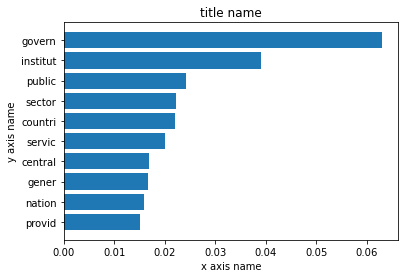


Topic id:  2
('includ', 0.062067676)
('servic', 0.05873867)
('refer', 0.038266435)
('other', 0.033289205)
('section', 0.031166408)
('group', 0.030733617)
('classif', 0.029262666)
('class', 0.025429307)
('offic', 0.024998615)
('statist', 0.0239433)


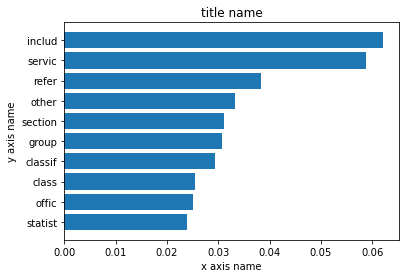


Topic id:  3
('market', 0.071567886)
('product', 0.042697817)
('expenditur', 0.039091595)
('protect', 0.03432346)
('capit', 0.03430665)
('produc', 0.034118336)
('output', 0.02944988)
('current', 0.027218716)
('environment', 0.025636744)
('transfer', 0.024948357)


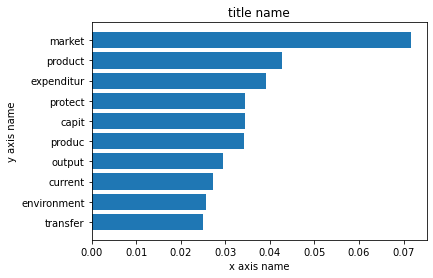


Topic id:  4
('includ', 0.0427207)
('agricultur', 0.038368754)
('water', 0.037478797)
('cover', 0.035760812)
('plant', 0.029547378)
('exclud', 0.027528688)
('normal', 0.027380647)
('refer', 0.026258953)
('perman', 0.021366293)
('surfac', 0.018489042)


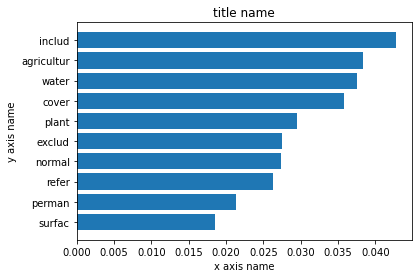


Topic id:  5
('enterpris', 0.087286994)
('activ', 0.052016675)
('refer', 0.04982976)
('inform', 0.037381265)
('agricultur', 0.022280065)
('standard', 0.021110762)
('survei', 0.020402135)
('product', 0.017599123)
('period', 0.017133595)
('statist', 0.016289182)


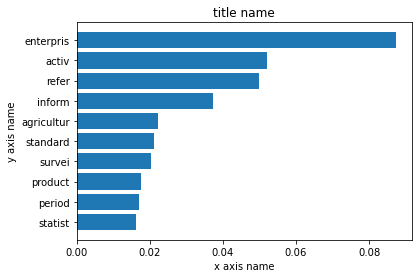


Topic id:  6
('activ', 0.036775734)
('technolog', 0.03461781)
('research', 0.03421304)
('develop', 0.031074405)
('resourc', 0.028810672)
('knowledg', 0.024364933)
('human', 0.022533957)
('perform', 0.021298045)
('manag', 0.018201292)
('standard', 0.0173393)


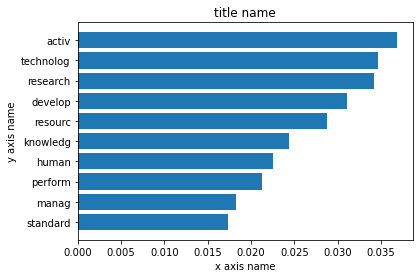


Topic id:  7
('person', 0.08867133)
('applic', 0.08537985)
('protect', 0.047104873)
('countri', 0.042024825)
('decis', 0.038944177)
('procedur', 0.031150505)
('statu', 0.027864018)
('intern', 0.023329815)
('refer', 0.023099463)
('legal', 0.020574328)


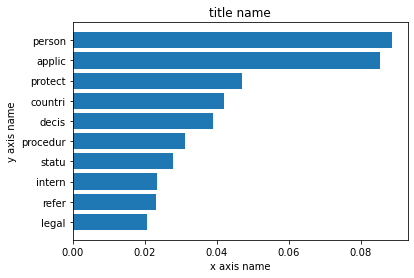


Topic id:  8
('number', 0.09786763)
('weight', 0.0837885)
('averag', 0.04894719)
('equival', 0.036435567)
('measur', 0.03544626)
('calcul', 0.035160955)
('total', 0.034559663)
('period', 0.028560743)
('ratio', 0.025346436)
('indic', 0.022418577)


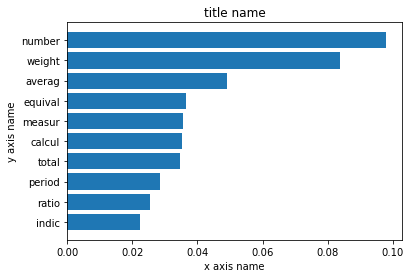


Topic id:  9
('product', 0.07898468)
('gross', 0.075723365)
('consumpt', 0.045825712)
('input', 0.032483257)
('output', 0.030829238)
('account', 0.030566199)
('balanc', 0.028858716)
('capit', 0.023707967)
('total', 0.023238992)
('measur', 0.021930842)


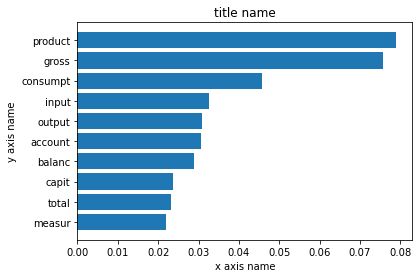


Topic id:  10
('price', 0.09417058)
('index', 0.06079852)
('person', 0.046334155)
('emploi', 0.040364288)
('period', 0.029917074)
('labour', 0.028822012)
('employe', 0.026586344)
('employ', 0.025498303)
('chang', 0.024571007)
('consum', 0.022236466)


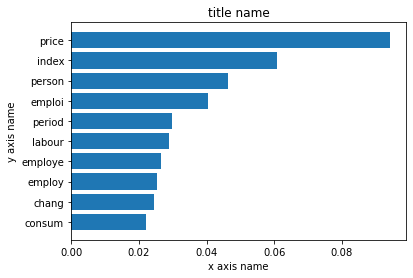


Topic id:  11
('activ', 0.107406676)
('statist', 0.05182723)
('servic', 0.05139819)
('product', 0.0409105)
('econom', 0.028650088)
('industri', 0.028303571)
('agricultur', 0.025041096)
('classif', 0.019662037)
('level', 0.016609244)
('european', 0.013899712)


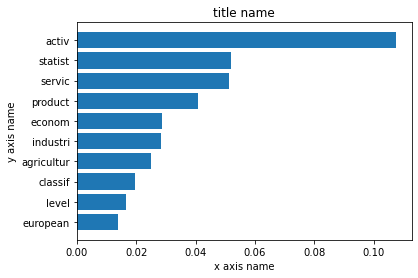


Topic id:  12
('household', 0.081498295)
('materi', 0.0554886)
('survei', 0.027605247)
('activ', 0.027374594)
('includ', 0.027374158)
('person', 0.026848175)
('agricultur', 0.026211623)
('famili', 0.026183197)
('organ', 0.024849692)
('product', 0.021408746)


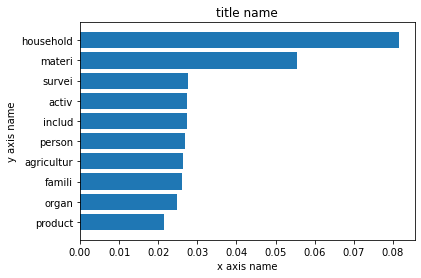


Topic id:  13
('transport', 0.11262511)
('vehicl', 0.0884795)
('countri', 0.06695117)
('enterpris', 0.04838406)
('place', 0.044886306)
('legal', 0.039700206)
('includ', 0.031772)
('nation', 0.028218264)
('report', 0.021074448)
('power', 0.020408824)


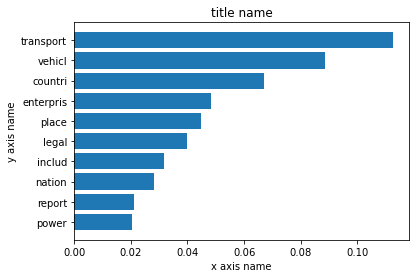


Topic id:  14
('european', 0.09688828)
('countri', 0.074721076)
('state', 0.06356602)
('member', 0.06318716)
('union', 0.053895835)
('statist', 0.030907081)
('trade', 0.0188179)
('januari', 0.018797962)
('region', 0.018388622)
('territori', 0.01655701)


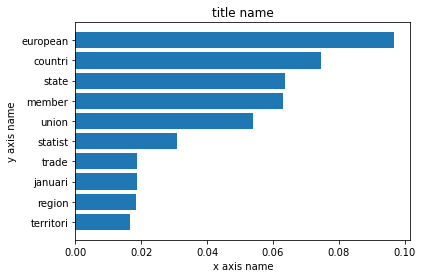


Topic id:  15
('incom', 0.09428247)
('financi', 0.061429497)
('social', 0.05973378)
('account', 0.041038774)
('asset', 0.03428864)
('contribut', 0.025511924)
('household', 0.023625776)
('dispos', 0.020319758)
('employe', 0.01946569)
('transfer', 0.018709438)


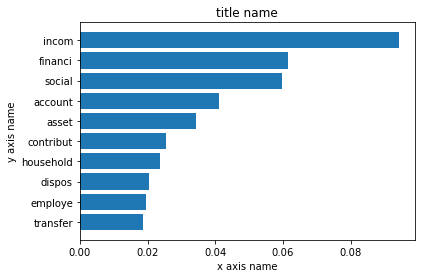


Topic id:  16
('product', 0.107903585)
('energi', 0.076249585)
('innov', 0.0628849)
('process', 0.06269504)
('servic', 0.034541734)
('includ', 0.030864187)
('improv', 0.023831936)
('technolog', 0.021315824)
('industri', 0.019695248)
('electr', 0.016673053)


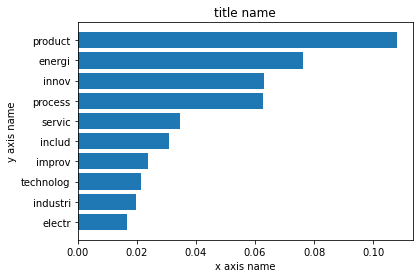


Topic id:  17
('resid', 0.07835984)
('account', 0.06848371)
('nation', 0.039581534)
('economi', 0.033522803)
('countri', 0.029951682)
('build', 0.028900525)
('direct', 0.024706403)
('econom', 0.021941053)
('state', 0.016779367)
('framework', 0.015753947)


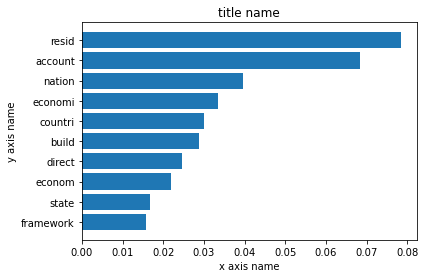


Topic id:  18
('health', 0.06232165)
('european', 0.047754873)
('state', 0.04087112)
('member', 0.038255263)
('survei', 0.037564296)
('regul', 0.03017989)
('council', 0.022030337)
('union', 0.021553528)
('method', 0.016824652)
('polici', 0.014598398)


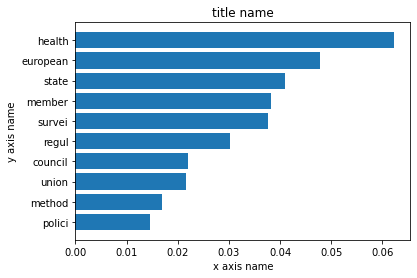


Topic id:  19
('popul', 0.12040051)
('death', 0.07759218)
('region', 0.059362747)
('urban', 0.03273642)
('group', 0.03272998)
('level', 0.030901287)
('peopl', 0.026286745)
('definit', 0.025579445)
('number', 0.022298243)
('defin', 0.021254491)


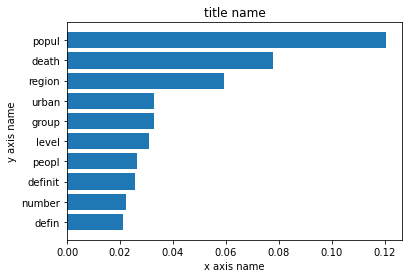


Topic id:  20
('indic', 0.089501135)
('econom', 0.07788543)
('environment', 0.04568424)
('employ', 0.026708603)
('social', 0.02595485)
('labour', 0.02582781)
('chang', 0.024777489)
('economi', 0.02086127)
('increas', 0.019478058)
('total', 0.016562888)


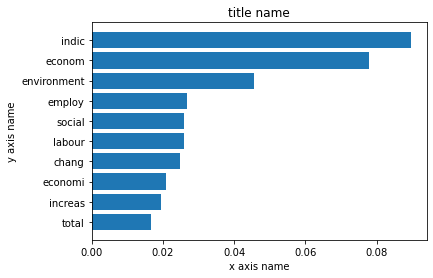

(20, 352)
                                           Topic Name     appli     charg  \
0   Public sector / central governmnent institutions.  0.001448  0.000052   
1                   Services and official statistics.  0.008028  0.005389   
2                             Capital and production.  0.000045  0.003452   
3                    Agriculture and water resources.  0.002724  0.000042   
4                              Enterprise activities.  0.000109  0.000031   
5                   R&D and technological activities.  0.000327  0.000043   
6           Protection application and asylum grants.  0.011352  0.000036   
7                                         Indicators.  0.001099  0.000041   
8         Production, consumption and gross accounts.  0.001649  0.000028   
9                Price indices and labour employment.  0.000044  0.000027   
10                             Activities statistics.  0.001932  0.000431   
11                          Activities and materials.  0.000697  0

In [16]:
import matplotlib.pyplot as plt
for topic_id in range(20):
    print('\nTopic id: ',topic_id+1 )
    top_words = [(a,b) for (a,b) in sorted(lda_model.show_topic(topic_id,topn=10),key=lambda x: x[1], reverse=True)]
    for t in range(len(top_words)):
        print(top_words[t])
    y_axis = [t[0] for t in top_words]
    x_axis = [t[1] for t in top_words] 
    plt.barh(y_axis,x_axis)
    plt.gca().invert_yaxis()
    plt.title('title name')
    plt.ylabel('y axis name')
    plt.xlabel('x axis name')
    plt.show()        
        
topic_names = ['Public sector / central governmnent institutions.',
'Services and official statistics.',
'Capital and production.',
'Agriculture and water resources.',
'Enterprise activities.',
'R&D and technological activities.',
'Protection application and asylum grants.',
'Indicators.',
'Production, consumption and gross accounts.',
'Price indices and labour employment.',
'Activities statistics.',
'Activities and materials.',
'Transport.',
'EU trade and treaties.',
'Social expenditure and households disposable income.',
'Innovation in energy production.',
'Economies and national accounts.',               
'Health surveillance in the EU Member States.',
'Regions and demographics.',
'Environmental economomics indicators.']



topics_terms_mat = lda_model.get_topics()
print(topics_terms_mat.shape)
#topics_terms_df = pd.DataFrame(columns=id2word.values())
topics_terms_df = pd.DataFrame()
for topic_id in range(20):
    topics_terms_df = topics_terms_df.append(pd.Series(topics_terms_mat[topic_id,:].transpose()), ignore_index=True)           
#    print('Topic ',topic_id)    
#   for t in lda_model.get_topic_terms(topic_id, topn=10):
#    print(topics_terms[topic_id,:])
    #print(id2word[t[0]],t[1])
#sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)  
topics_terms_df.rename(columns=id2word, inplace=True)
#for topic_id in range(20):
#    topics_terms_df.loc[topic_id,'Top 5 topic keywords'] = [(a,b) for (a,b) in sorted(lda_model.show_topic(0,topn=5),key=lambda x: x[1], reverse=True)]
topics_terms_df.insert(0,'Topic Name',topic_names)
print(topics_terms_df)
print(topics_terms_df.shape)


In [17]:
import numpy as np
np.sum(lda_model.get_topics(),axis=1)

array([1.        , 1.0000001 , 1.        , 0.9999999 , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999994,
       1.        , 1.        , 0.9999999 , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999994],
      dtype=float32)

In [20]:
topics_terms_df.to_csv('topics_terms_df.write_csv')